In [1]:
import mhlwcovidparser
mcp = mhlwcovidparser.mhlwCovidParser()
data = mcp.prefecture(["ALL"])

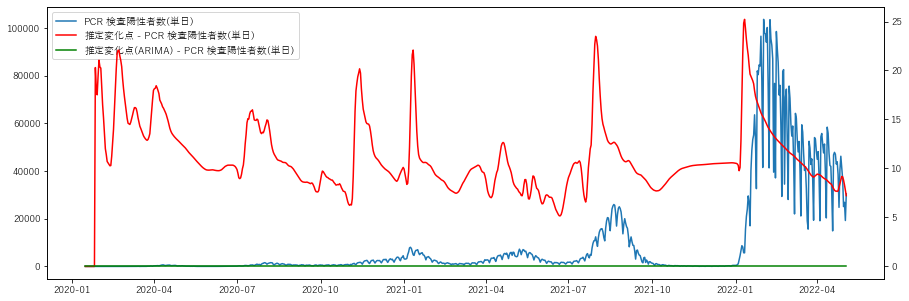

In [2]:
import matplotlib
import matplotlib.pyplot
import changefinder

class changefinder_calculator():
    def __init__(self, data):
        self.data = data
    def changefinder_calculator(self, column):
        cf = changefinder.ChangeFinder(r=0.05, order=1, smooth=7)
        ret = []
        for i in self.data[column]:
            score = cf.update(i)
            ret.append(score)
        return ret

    def changefinderARIMA_calculator(self, column):
        cf = changefinder.ChangeFinderARIMA()
        ret = []
        for i in self.data[column]:
            score = cf.update(i)
            ret.append(score)
        return ret

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
# print(data)
fig = matplotlib.pyplot.figure(figsize=(15,5))
ax1 = fig.add_subplot(111)

ax1.plot(data, label = "PCR 検査陽性者数(単日)")

# data['変化点スコア - PCR 検査陽性者数(単日)'] = changefinder_calculator('PCR 検査陽性者数(単日)')

ax2 = ax1.twinx()

cc = changefinder_calculator(data)

ax2.plot(data.index,
         cc.changefinder_calculator('ALL'),
         label = '推定変化点 - PCR 検査陽性者数(単日)',
         color = 'r')
ax2.plot(data.index,
         cc.changefinderARIMA_calculator('ALL'),
         label = '推定変化点(ARIMA) - PCR 検査陽性者数(単日)',
         color = 'g')


hans1, labs1 = ax1.get_legend_handles_labels()
hans2, labs2 = ax2.get_legend_handles_labels()

ax1.legend(hans1+hans2, labs1+labs2)

matplotlib.pyplot.show()